# Homework

**Homework is done by the student of group 331 Ryakhovskiy Aleksey**


The homework is to prepare a report for the Ministry of Transport, revealing the nature and characteristics of flight delays. The report should help identify problem areas and contribute to decision-making. Therefore, strive not to state general facts, but to show problems. For example, the fact 'the average departure delay is 15 minutes' by itself says little and does not help to understand why this is happening. On the contrary, a graph showing that on Mondays delays increase threefold compared to other days against the background of an increase in the number of flights and passengers suggests a possible cause of the problem: airports cannot cope with uneven load.

The report should be in the form of a notebook with a clear structure. At the beginning of the Markdown cell there is a brief description of the question under study (what we will study), then the code and all its outputs (tables, graphs, values), then again in the Markdown cell in which your brief conclusion is formulated.

The report should contain at least **5 results** confirmed by graphs. For variety of material, use different types of diagrams. All graphs should be provided with the necessary signatures (axis designations, title, color scheme legend).

To solve the problems, use the methods of the `pandas` library.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

flights = pd.read_csv('datasets/flights.csv', low_memory=False)
airports = pd.read_csv('datasets/airports.csv', low_memory=False)
airlines = pd.read_csv('datasets/airlines.csv', low_memory=False)

In [5]:
flights = flights[flights.ORIGIN_AIRPORT.isin(airports.IATA_CODE) & flights.DESTINATION_AIRPORT.isin(airports.IATA_CODE)] # drop unknown airports
#flights = flights.dropna(subset = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY']) # del rows with nan in DEP_DELAY or ARR_DELAY cols
flights = flights.dropna(subset = ['DEPARTURE_DELAY']) # del rows with nan in DEP_DELAY col

In [6]:
flights['DATE'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']]) # new date col
flights.drop(columns=['YEAR', 'MONTH', 'DAY'], inplace=True) # delete old date data
cols = ['DATE'] + [col for col in flights.columns if col != 'DATE'] # date col to first position
flights = flights[cols]

In [7]:
airlines_dict = dict(zip(airlines['IATA_CODE'], airlines['AIRLINE']))  # Create dict {IATA_CODE: AIRLINE}
airport_dict = dict(zip(airports['IATA_CODE'], airports['AIRPORT'])) # Create dict {IATA_CODE: AIRPORT}
city_dict = dict(zip(airports['IATA_CODE'], airports['CITY'])) # Create dict {IATA_CODE: CITY}

In [8]:
airports.loc[airports['IATA_CODE'] == 'ECP', ['LATITUDE', 'LONGITUDE']] = [30.357851, -85.795602] # add lat and long to ECP

## Hypothesis 1: Some aircraft systematically experience more frequent delays than others.

Before analyzing the data, we hypothesize that certain aircraft may be more prone to frequent and severe delays than others. This could be due to airline-specific operational inefficiencies, maintenance schedules, or airport congestion affecting certain fleets disproportionately. By identifying the aircraft with the highest median delays, we aim to determine whether delays are systemic within specific airlines or if they are related to external factors. If patterns emerge, this could lead to policy recommendations for improving airline reliability and minimizing passenger inconvenience.

In [11]:
flights_tail = flights.dropna(subset=['TAIL_NUMBER']) # drop rows without tail number 
flights_tail[flights_tail['DEPARTURE_DELAY'] < 0] = 0 
tail_to_airline = flights_tail[['TAIL_NUMBER', 'AIRLINE']].drop_duplicates().set_index('TAIL_NUMBER') # matching the aircraft to the airline

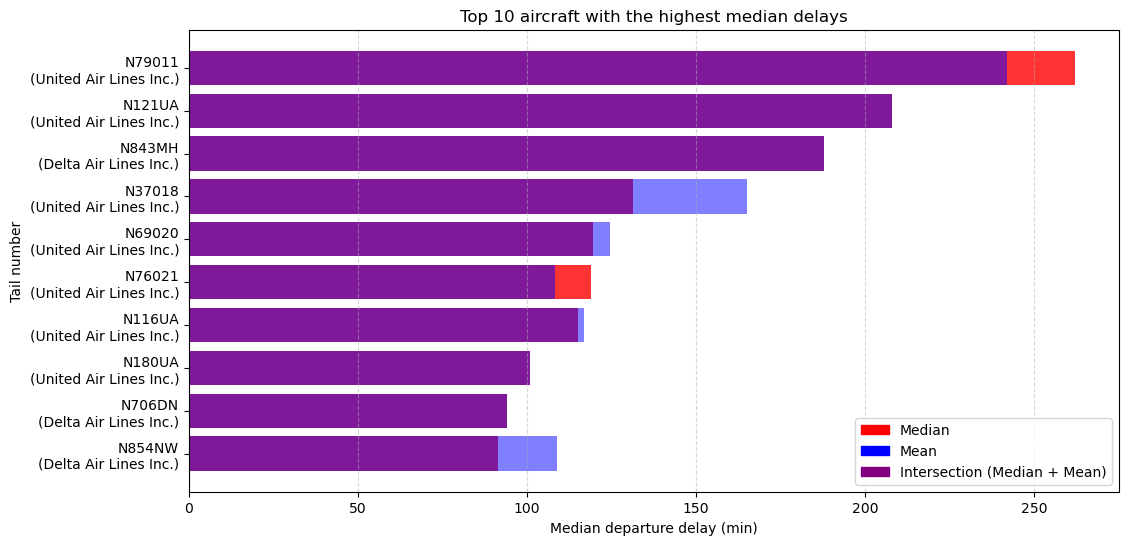

In [12]:
tail_delays_median = flights_tail.groupby('TAIL_NUMBER')['DEPARTURE_DELAY'].agg(['mean', 'median'])
top_tail_delays = tail_delays_median.sort_values(by='median', ascending=False).head(10)

top_tail_delays = top_tail_delays.merge(tail_to_airline, left_index=True, right_index=True)
top_tail_delays['AIRLINE'] = top_tail_delays['AIRLINE'].map(airlines_dict)
top_tail_delays['label'] = top_tail_delays.index + '\n(' + top_tail_delays['AIRLINE'] + ')'

plt.figure(figsize=(12, 6))

plt.barh(top_tail_delays['label'], top_tail_delays['median'], color='red', alpha=0.8, label='Median')
plt.barh(top_tail_delays['label'], top_tail_delays['mean'], color='blue', alpha=0.5, label='Mean')

median_patch = mpatches.Patch(color='red', label='Median')
mean_patch = mpatches.Patch(color='blue', label='Mean')
intersection_patch = mpatches.Patch(color='purple', label='Intersection (Median + Mean)')

plt.legend(handles=[median_patch, mean_patch, intersection_patch], loc='lower right')

plt.xlabel('Median departure delay (min)')
plt.ylabel('Tail number')
plt.title('Top 10 aircraft with the highest median delays')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

The data shows that certain aircraft (such as those operated by United Airlines and Delta Airlines) consistently experience long departure delays, sometimes exceeding 150 minutes. This suggests potential systemic issues, such as maintenance problems, scheduling inefficiencies, or airport congestion. The U.S. Department of Transportation should investigate these patterns and consider implementing penalties for frequent delays or incentives for improved punctuality. A reliability rating system for airlines and specific aircraft could encourage better operational efficiency and accountability.

## Hypothesis 2: Some airlines delay flights more often than others

Some airlines systematically experience higher delays due to operational inefficiencies, affecting both their overall performance and specific aircraft.

<Figure size 1200x600 with 0 Axes>

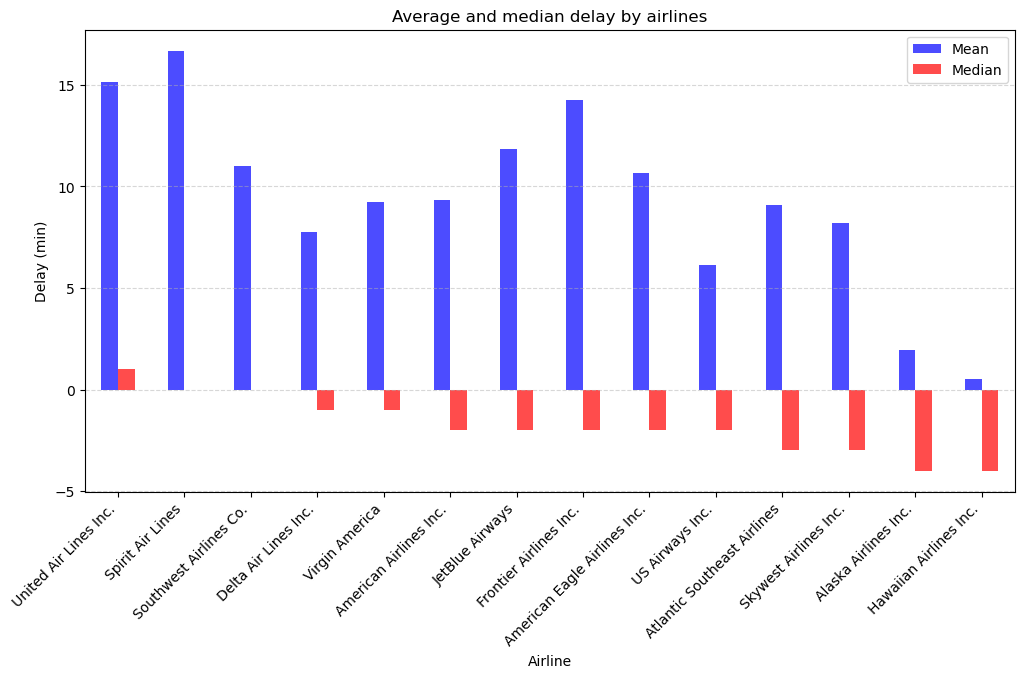

In [16]:
airline_delays = flights.groupby('AIRLINE')['DEPARTURE_DELAY'].agg(['mean', 'median']).sort_values(by='median', ascending=False)

airline_delays.index = airline_delays.index.map(airlines_dict)

plt.figure(figsize=(12, 6))
airline_delays[['mean', 'median']].plot(kind='bar', figsize=(12, 6), color=['blue', 'red'], alpha=0.7)

plt.ylabel('Delay (min)')
plt.xlabel('Airline')
plt.title('Average and median delay by airlines')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(['Mean', 'Median'])
plt.show()


From this graph we can see that in fact almost all airlines depart usually on time or even earlier, the deviation at the median is noticeable for only one airline. However, the average graph shows that all airlines have high averages, this is due to rare but severe delays.

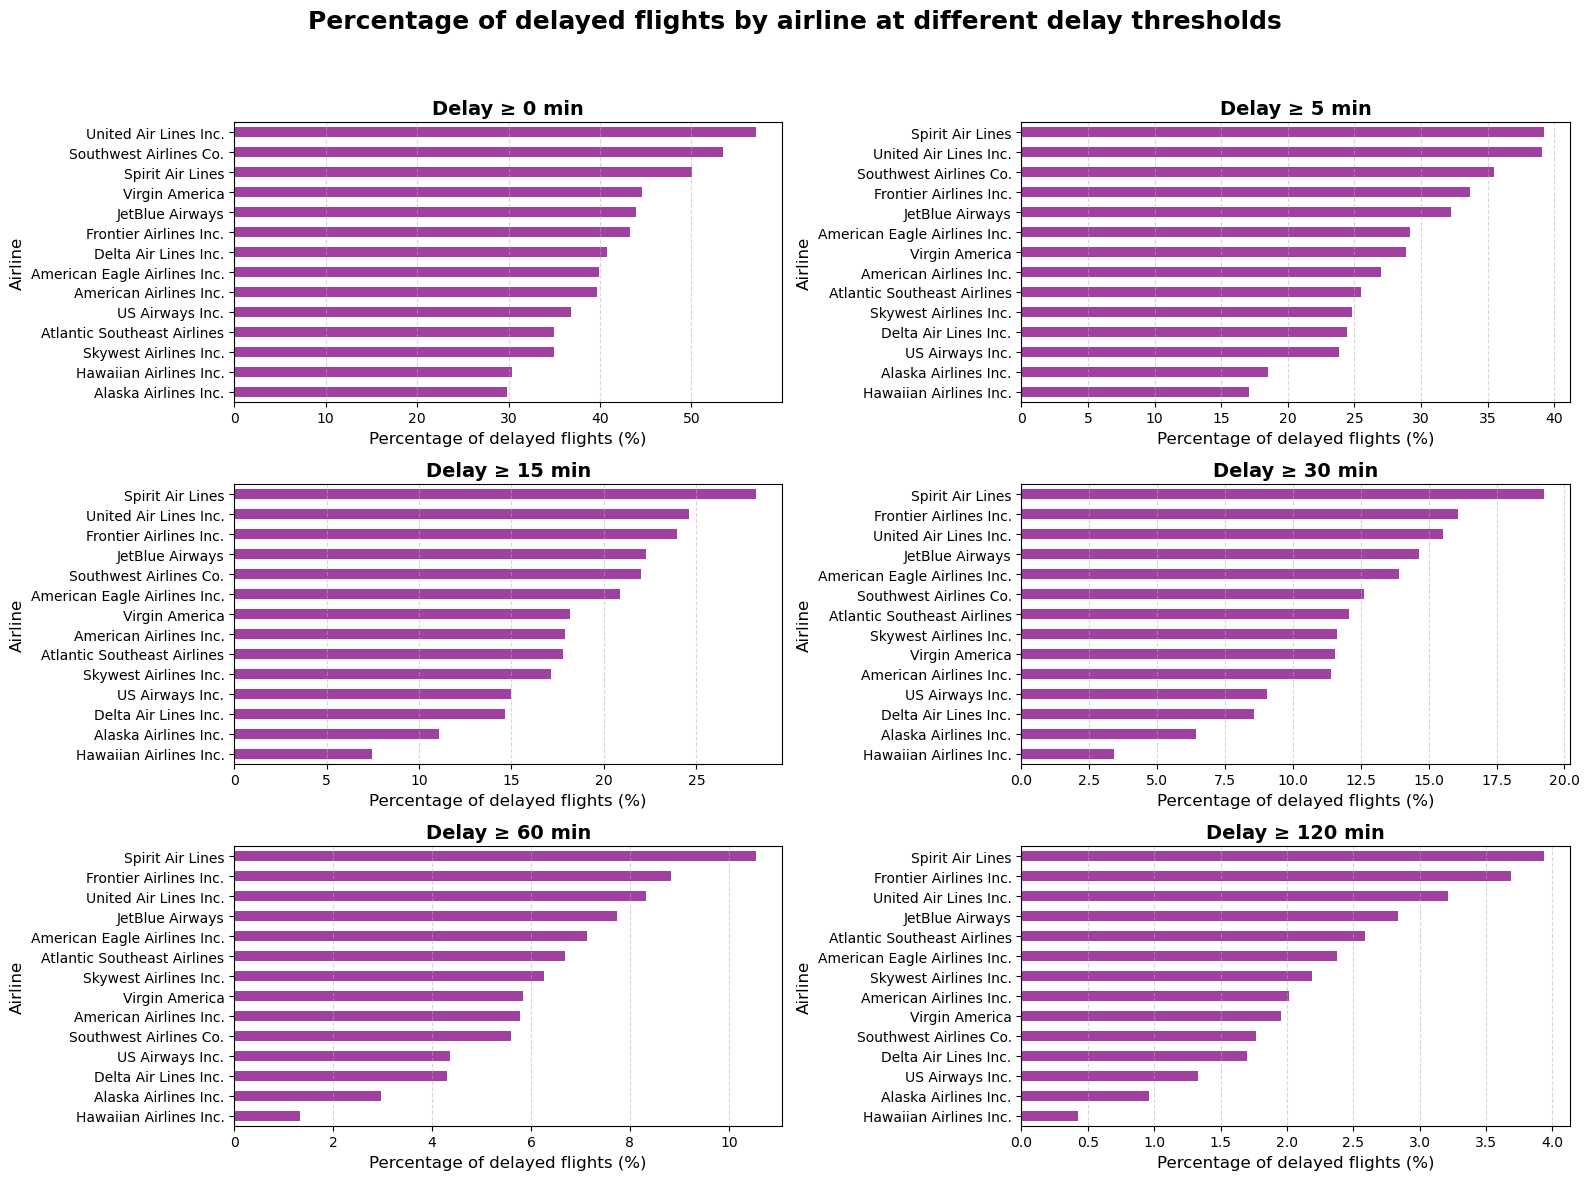

In [18]:
delay_thresholds = [0, 5, 15, 30, 60, 120]
total_flights = flights['AIRLINE'].value_counts()

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Percentage of delayed flights by airline at different delay thresholds', fontsize=18, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, threshold in enumerate(delay_thresholds):
    row, col = divmod(i, 2)
    delayed_flights = flights[flights['DEPARTURE_DELAY'] >= threshold]['AIRLINE'].value_counts()
    airline_delay_rate = (delayed_flights / total_flights * 100).dropna().sort_values(ascending=False)

    airline_delay_rate.index = airline_delay_rate.index.map(airlines_dict)

    airline_delay_rate.plot(kind='barh', color='purple', alpha=0.75, ax=axes[row, col])
    
    axes[row, col].set_title(f'Delay ≥ {threshold} min', fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel('Percentage of delayed flights (%)', fontsize=12)
    axes[row, col].set_ylabel('Airline', fontsize=12)
    axes[row, col].invert_yaxis()
    axes[row, col].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The analysis of airline delays reveals a clear pattern: some airlines consistently experience higher delays across all thresholds, and the worst-performing airlines also have individual aircraft that systematically suffer long delays. The first graph (from Hypothesis 1) showed that specific aircraft operated by certain airlines (e.g., United Airlines, Delta Airlines) frequently experience extreme delays, indicating potential issues with fleet management, maintenance schedules, or inefficient operations.

The second graph highlights that some airlines, such as Spirit Airlines, United Airlines, and Frontier Airlines, have significantly higher average delays compared to others, with a noticeable gap between the mean and median delay. This suggests that occasional extreme delays inflate the average delay time, rather than delays being evenly distributed across flights. The third graph, which examines the percentage of delayed flights at different thresholds (≥0, ≥5, ≥15, ≥30, ≥60, and ≥120 minutes), further supports this by showing that the same airlines dominate the ranking of delayed flights, reinforcing the idea that their operations are systematically less efficient.

In contrast, airlines like Alaska Airlines and Hawaiian Airlines consistently show the lowest delay percentages and the smallest difference between mean and median delays, indicating more reliable scheduling and fleet management practices.

To address these issues, airlines should focus on identifying and resolving problems with specific aircraft that frequently experience long delays, adjusting maintenance schedules, and improving crew and aircraft availability. Optimizing flight planning and increasing the number of backup aircraft could significantly reduce the risk of extreme delays. The government should consider introducing a transparency-based ranking system, where airlines are categorized into a 'green list' for punctual carriers and a 'red list' for airlines with frequent delays. This could incentivize better performance and provide passengers with clearer expectations when choosing airlines.

Conclusion: Chronic flight delays are not random occurrences but the result of systemic inefficiencies at both the airline and aircraft level. Addressing fleet management, scheduling inefficiencies, and introducing regulatory measures can significantly improve the punctuality and reliability of air travel.

## Hypothesis 3: Delay at some airports is higher than at others

Some airports systematically experience higher departure delays than others, which may indicate operational inefficiencies, infrastructure limitations, or air traffic congestion.

In [22]:
flights_clean = flights
flights_clean[flights_clean['DEPARTURE_DELAY'] < 0] = 0 

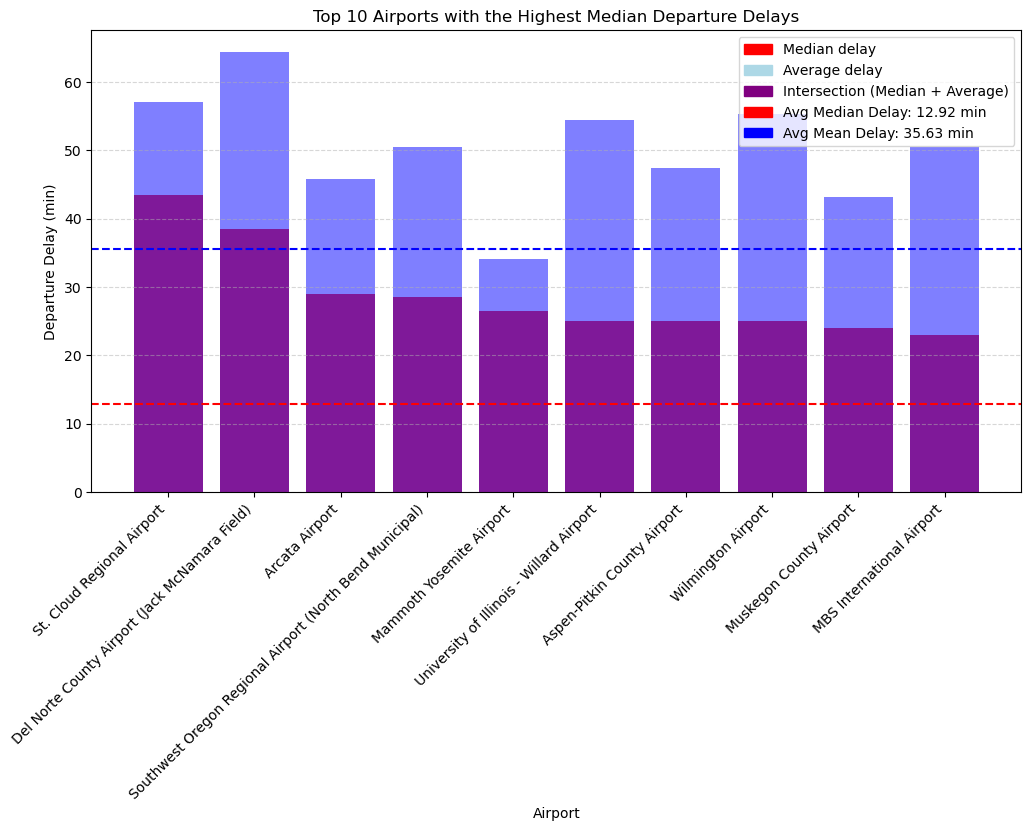

In [23]:
airport_delays_median = flights_clean.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].agg(['mean', 'median'])

top_airport_delays = airport_delays_median.sort_values(by='median', ascending=False).head(10)

top_airport_delays['AIRPORT_FULL'] = top_airport_delays.index.map(airport_dict)
top_airport_delays['label'] = top_airport_delays['AIRPORT_FULL'].fillna(top_airport_delays.index.to_series())

average_median_delay = airport_delays_median['median'].mean()
average_mean_delay = airport_delays_median['mean'].mean()

plt.figure(figsize=(12, 6))

plt.bar(top_airport_delays['label'], top_airport_delays['median'], color='red', alpha=0.8, label='Median')
plt.bar(top_airport_delays['label'], top_airport_delays['mean'], color='blue', alpha=0.5, label='Mean')

plt.axhline(y=average_median_delay, color='red', linestyle='--', label=f'Avg Median Delay: {average_median_delay:.2f} min')
plt.axhline(y=average_mean_delay, color='blue', linestyle='--', label=f'Avg Mean Delay: {average_mean_delay:.2f} min')

median_patch = mpatches.Patch(color='red', label='Median delay')
mean_patch = mpatches.Patch(color='lightblue', label='Average delay')
intersection_patch = mpatches.Patch(color='purple', label='Intersection (Median + Average)')
avg_median_patch = mpatches.Patch(color='red', label=f'Avg Median Delay: {average_median_delay:.2f} min')
avg_mean_patch = mpatches.Patch(color='blue', label=f'Avg Mean Delay: {average_mean_delay:.2f} min')

plt.legend(handles=[median_patch, mean_patch, intersection_patch, avg_median_patch, avg_mean_patch], loc='upper right')

plt.ylabel('Departure Delay (min)')
plt.xlabel('Airport')
plt.title('Top 10 Airports with the Highest Median Departure Delays')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.show()

The analysis of the top 10 airports with the highest median departure delays indicates that regional airports experience the most significant delays compared to major hubs. This trend suggests that limited runway capacity, reduced flight frequency, and outdated infrastructure contribute to prolonged departure times. Additionally, regional airports may lack the resources and flexibility to handle unexpected disruptions efficiently.

To address these issues, the U.S. Department of Transportation should focus on several key areas. First, infrastructure improvements should be prioritized in high-delay airports, including the modernization of air traffic control systems and runway expansions. Second, flight scheduling optimization is necessary to better distribute air traffic and prevent bottlenecks. Third, airline accountability measures should be strengthened to enforce stricter departure punctuality regulations and ensure proactive delay management. Lastly, weather preparedness initiatives should be implemented, particularly for regional airports that are more vulnerable to disruptions caused by adverse weather conditions.

By improving infrastructure, optimizing scheduling, enforcing regulations, and enhancing contingency planning, the efficiency of airport operations can be significantly improved, leading to reduced delays and a better passenger experience.

## Hypothesis 4: Delay in some cities is worse than at other

There is a strong correlation between cities and airport delays, suggesting that delays are not only an airport-specific issue but also a broader urban infrastructure problem.

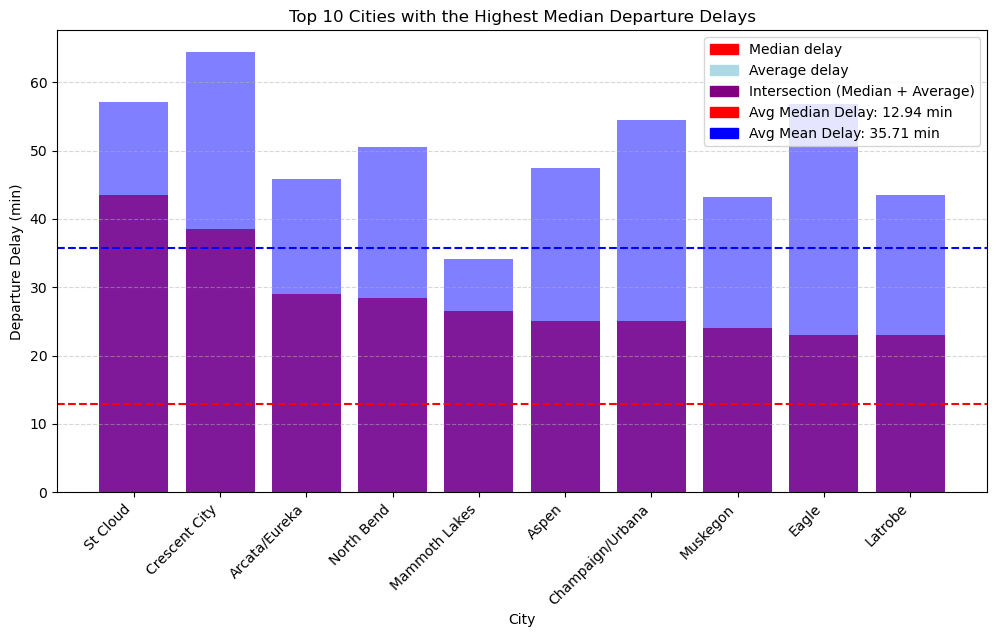

In [27]:
city_delays_median = flights_clean.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].agg(['mean', 'median'])
city_delays_median['CITY'] = city_delays_median.index.map(city_dict)

city_delays_aggregated = city_delays_median.groupby('CITY').agg({'mean': 'mean', 'median': 'mean'}).dropna()

top_city_delays = city_delays_aggregated.sort_values(by='median', ascending=False).head(10)

average_median_delay = city_delays_aggregated['median'].mean()
average_mean_delay = city_delays_aggregated['mean'].mean()

plt.figure(figsize=(12, 6))

plt.bar(top_city_delays.index, top_city_delays['median'], color='red', alpha=0.8, label='Median')
plt.bar(top_city_delays.index, top_city_delays['mean'], color='blue', alpha=0.5, label='Mean')

plt.axhline(y=average_median_delay, color='red', linestyle='--', label=f'Avg Median Delay: {average_median_delay:.2f} min')
plt.axhline(y=average_mean_delay, color='blue', linestyle='--', label=f'Avg Mean Delay: {average_mean_delay:.2f} min')

median_patch = mpatches.Patch(color='red', label='Median delay')
mean_patch = mpatches.Patch(color='lightblue', label='Average delay')
intersection_patch = mpatches.Patch(color='purple', label='Intersection (Median + Average)')
avg_median_patch = mpatches.Patch(color='red', label=f'Avg Median Delay: {average_median_delay:.2f} min')
avg_mean_patch = mpatches.Patch(color='blue', label=f'Avg Mean Delay: {average_mean_delay:.2f} min')

plt.legend(handles=[median_patch, mean_patch, intersection_patch, avg_median_patch, avg_mean_patch], loc='upper right')
plt.ylabel('Departure Delay (min)')
plt.xlabel('City')
plt.title('Top 10 Cities with the Highest Median Departure Delays')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.show()


The data reveal that cities with the most delayed airports also rank high in overall departure delays. This indicates that the issue extends beyond individual airports and may be linked to insufficient airport capacity, congestion, and infrastructure limitations in these cities.

To address this, the U.S. Department of Transportation should consider expanding existing airport infrastructure and evaluating the feasibility of constructing additional airports in high-delay cities. Additionally, local authorities should be engaged through formal reports and recommendations, encouraging municipal governments to take action in improving urban transport networks and airport accessibility.

## Hypothesis 5: Delay on some days of the week more often than others

Delays may not be evenly distributed across all days of the week, and certain airports might experience significantly higher delays on specific days. This could be due to increased passenger flow, inefficient scheduling, weather conditions, or operational limitations. By analyzing the most delayed airports separately, we can identify patterns and determine whether delays are concentrated on specific days or persist throughout the week. Understanding these trends will help in optimizing schedules, improving infrastructure, and implementing better resource management strategies.

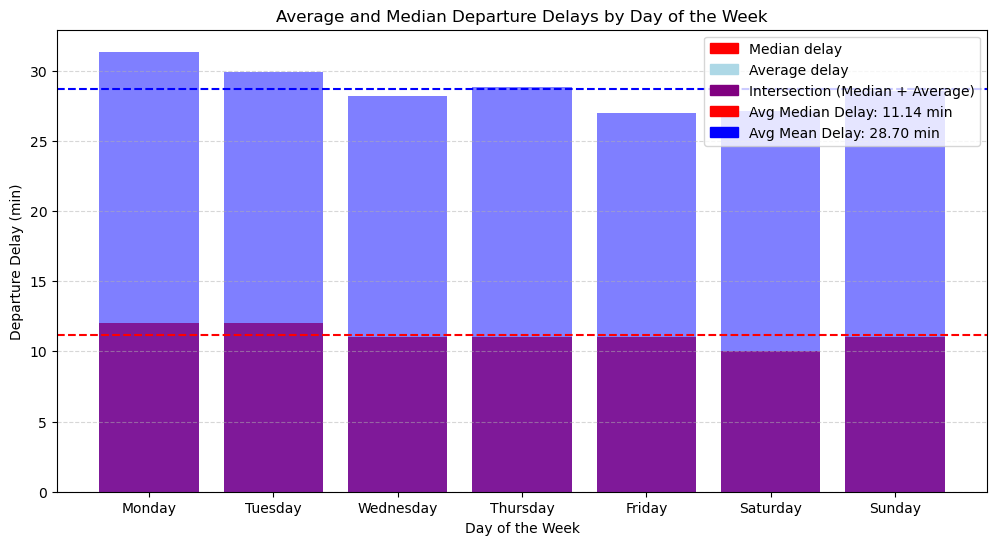

In [31]:
weekday_mapping = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
    5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}

weekday_delays = flights_clean.groupby('DAY_OF_WEEK')['DEPARTURE_DELAY'].agg(['mean', 'median'])
weekday_delays.index = weekday_delays.index.map(weekday_mapping)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_delays = weekday_delays.reindex(weekday_order)

average_median_delay = weekday_delays['median'].mean()
average_mean_delay = weekday_delays['mean'].mean()

plt.figure(figsize=(12, 6))

plt.bar(weekday_delays.index, weekday_delays['median'], color='red', alpha=0.8, label='Median')
plt.bar(weekday_delays.index, weekday_delays['mean'], color='blue', alpha=0.5, label='Mean')

plt.axhline(y=average_median_delay, color='red', linestyle='--', label=f'Avg Median Delay: {average_median_delay:.2f} min')
plt.axhline(y=average_mean_delay, color='blue', linestyle='--', label=f'Avg Mean Delay: {average_mean_delay:.2f} min')

median_patch = mpatches.Patch(color='red', label='Median delay')
mean_patch = mpatches.Patch(color='lightblue', label='Average delay')
intersection_patch = mpatches.Patch(color='purple', label='Intersection (Median + Average)')
avg_median_patch = mpatches.Patch(color='red', label=f'Avg Median Delay: {average_median_delay:.2f} min')
avg_mean_patch = mpatches.Patch(color='blue', label=f'Avg Mean Delay: {average_mean_delay:.2f} min')

plt.legend(handles=[median_patch, mean_patch, intersection_patch, avg_median_patch, avg_mean_patch], loc='upper right')
plt.ylabel('Departure Delay (min)')
plt.xlabel('Day of the Week')
plt.title('Average and Median Departure Delays by Day of the Week')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

The graph provides a general overview of departure delays across all days of the week. However, it does not reveal any significant variations between different weekdays—delays appear fairly uniform. This lack of contrast suggests that averaging delays across all airports may be masking underlying issues. Therefore, a deeper dive into individual airports is necessary to identify patterns and problem areas.

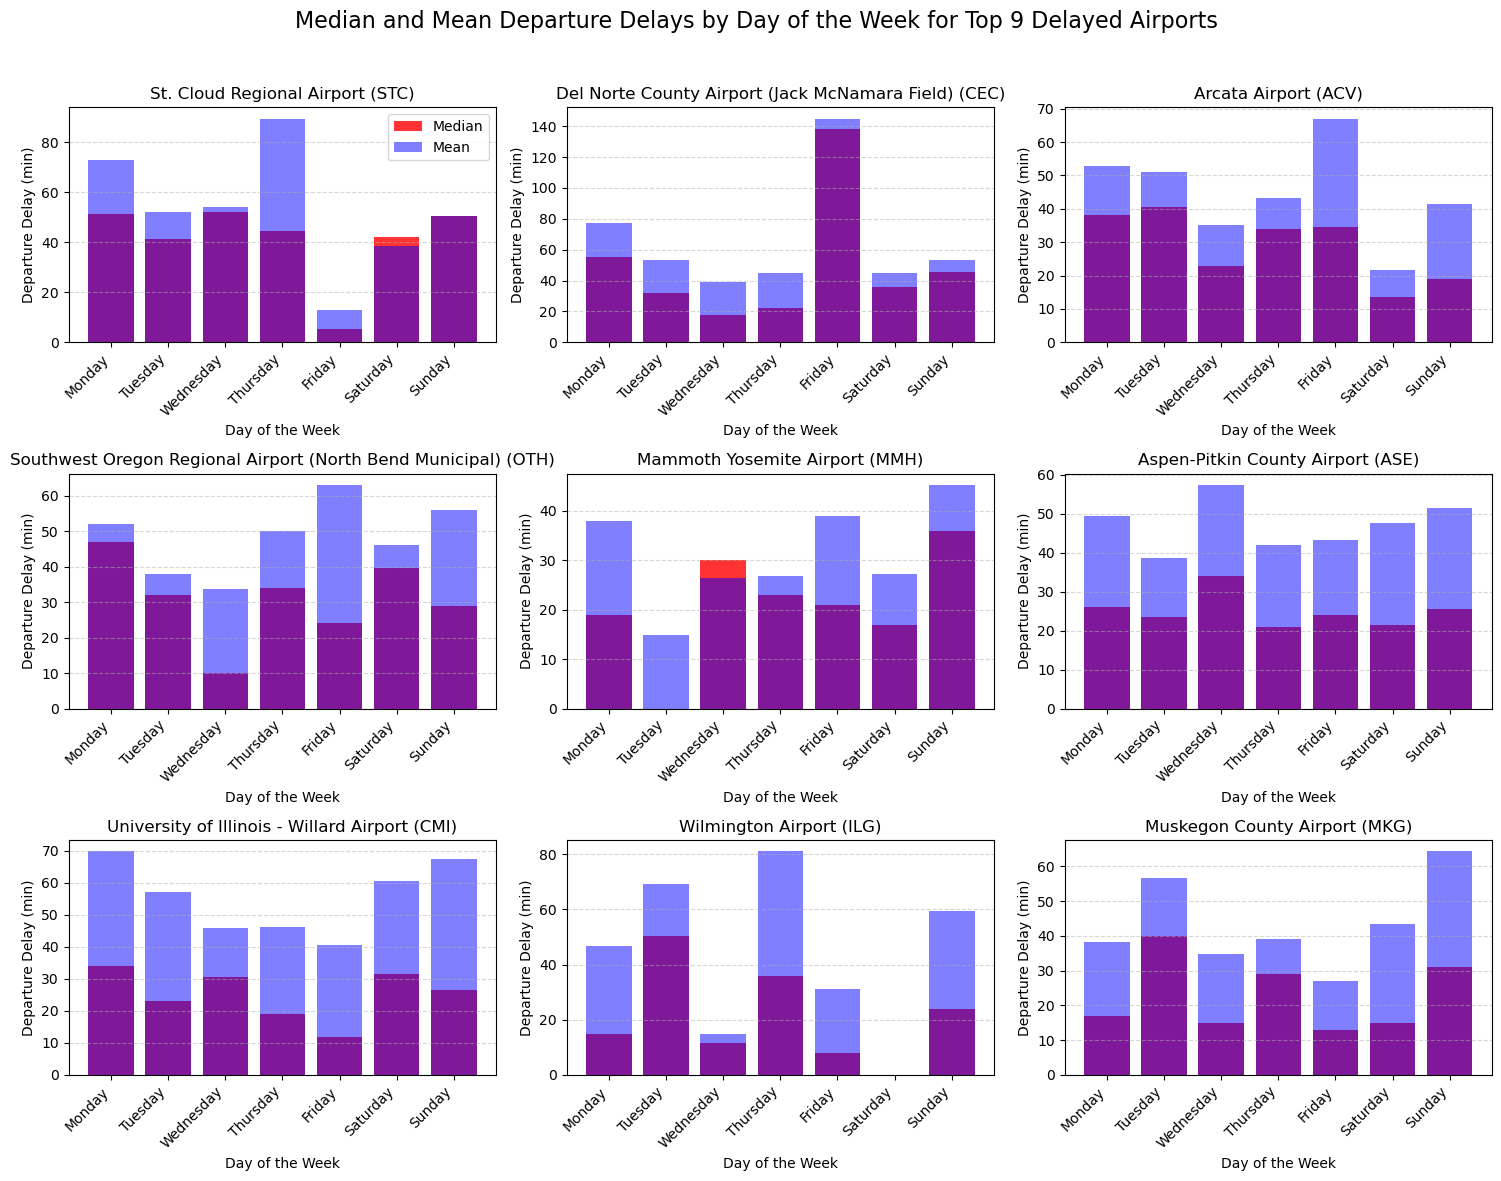

In [33]:
top_airports = flights_clean.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].median().nlargest(9).index
top_airports_named = [airport_dict.get(code, code) for code in top_airports]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Median and Mean Departure Delays by Day of the Week for Top 9 Delayed Airports', fontsize=16)

for ax, airport_code, airport_name in zip(axes.flat, top_airports, top_airports_named):
    airport_data = flights_clean[flights_clean['ORIGIN_AIRPORT'] == airport_code]
    weekday_delays = airport_data.groupby('DAY_OF_WEEK')['DEPARTURE_DELAY'].agg(['mean', 'median'])

    weekday_delays.index = weekday_delays.index.map(weekday_mapping)
    weekday_delays = weekday_delays.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    ax.bar(weekday_delays.index, weekday_delays['median'], color='red', alpha=0.8, label='Median')
    ax.bar(weekday_delays.index, weekday_delays['mean'], color='blue', alpha=0.5, label='Mean')

    ax.set_title(f'{airport_name} ({airport_code})')
    ax.set_ylabel('Departure Delay (min)')
    ax.set_xlabel('Day of the Week')
    ax.set_xticklabels(weekday_delays.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)


axes[0, 0].legend(['Median', 'Mean'], loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The analysis of the nine most delayed airports shows that some experience sharp spikes in delays on specific days, like Del Norte County Airport (CEC) on Saturday and St. Cloud Regional Airport (STC) on Sunday, while others, such as Aspen-Pitkin County (ASE) and Muskegon County (MKG), have consistently high delays throughout the week. Weekends tend to show more delays, likely due to increased passenger traffic, weather conditions, or staffing shortages. To address this, the U.S. Department of Transportation should investigate airports with extreme delays on specific days, analyze weekend congestion and adjust workforce schedules, upgrade infrastructure in consistently delayed airports by expanding runways and adding gates, and encourage airlines to distribute flights more evenly across the week to reduce peak-day bottlenecks. These steps will help improve airport efficiency and reduce delays.